In [1]:
import torch
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import os
import base64
from PIL import Image
import io

/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ensure the entire text in each cell is displayed without truncation
pd.set_option('display.max_colwidth', None)

# Adjusting display width might not be necessary depending on your pandas version, but it's here for completeness
pd.set_option('display.width', None)

pew = pd.read_csv('../dataset/pew_dataset/metadata.csv')
pew['imgPath'] = pew['imgPath'].str.replace('imgs', '../dataset/pew_dataset/pew_imgs')
statista = pd.read_csv('../dataset/statista_dataset/metadata.csv')
statista['imgPath'] = statista['imgPath'].str.replace('out/two_col/imgs', '../dataset/statista_dataset/statista_imgs')

In [3]:
columns = ['title','caption','imgPath']
# Filtering the DataFrame to include only the specified columns
pew_df = pew[columns]
statista_df = statista[columns]
combined_df = pd.concat([pew_df, statista_df], ignore_index=True)

In [4]:
combined_df

,title,caption,imgPath
0,"Foreign-born population in the United States, 1850-2018","The foreign-born population residing in the U.S. reached a record 44.8 million, or 13.7% of the U.S. population, in 2018. This immigrant population has more than quadrupled since the 1960s, when the 1965 Immigration and Naturalization Act took effect. Though growth has begun to slow in recent years, the number of immigrants living in the United States is projected to almost double by 2065.",../dataset/pew_dataset/pew_imgs/1.png
1,"English proficiency among U.S. immigrants, 1980-2018","Since 1980, the share of immigrants who are proficient in English (those who speak only English at home or speak English at least “very well”) has declined, though it has increased slightly in recent years. This decline has been driven entirely by those who speak only English at home, which fell from 30% of immigrants ages 5 and older in 1980 to 17% in 2018. The share who speaks English “very well,” meanwhile, has increased slightly, from 27% to 37% over the same time period.",../dataset/pew_dataset/pew_imgs/2.png
2,"Languages spoken among U.S. immigrants, 2018","Among the nation’s immigrants, Spanish is by far the most spoken non-English language (42% of immigrants say they speak Spanish at home), but it is not the only non-English language spoken by immigrants. Some 6% of immigrants speak Chinese (including Mandarin and Cantonese), 5% speak Hindi or a related language, 4% speak Filipino or Tagalog, 3% speak Vietnamese, 3% speak French and 2% speak Dravidian.",../dataset/pew_dataset/pew_imgs/3.png
3,"Hispanic population in the U.S., 2000-2017","There were nearly 60 million Latinos in the United States in 2017, accounting for approximately 18% of the total U.S. population. In 1980, with a population of 14.8 million, Hispanics made up just 6.5% of the total U.S. population. For more, read the accompanying blog post, “Key facts about U.S. Hispanics and their diverse heritage.” For facts on the foreign-born population in the United States, see our profile on U.S. immigrants.",../dataset/pew_dataset/pew_imgs/4.png
4,Weekly broadcast audience for top 20 NPR-affiliated radio stations,"The top 20 NPR-affiliated public radio stations (by listenership) had on average a total weekly listenership of about 11 million in 2018, about the same as in 2017. (This includes listeners of NPR programming as well as original or other syndicated content aired on these stations.)",../dataset/pew_dataset/pew_imgs/5.png
...,...,...,...
29349,"\r\n Distribution of cyber stalking victims in 2013, by marital status\r\n","This statistic presents the distribution of cyber stalking victims in 2013, by marital status. According to cases handled by cyber harassment support group WHOA, 52 percent of reporting victims identified themselves as single.",../dataset/statista_dataset/statista_imgs/27864.png
29350,"\r\n Total number of dwellings in Great Britain from 2003 to 2017 \r\n \r\n (in 1,000s)\r\n","This statistic displays the total number of dwellings in Great Britain from 2003 to 2017. It can be seen that the number of dwellings in Great Britain increased year on year during the period observed, from approximately 25.16 million dwellings in 2003 to over 27.95 million dwellings in 2017.",../dataset/statista_dataset/statista_imgs/27865.png
29351,"\r\n Results in the European Parliament elections in the United Kingdom (UK) in 2014, by national party\r\n","This statistic shows the political parties and their respective results in the European Parliament Elections in the United Kingdom (UK) in 2014. In 2014, UKIP had 27 percent of the votes.",../dataset/statista_dataset/statista_imgs/27866.png
29352,\r\n Average annual expenditure on curtains and draperies per consumer unit in the United States from 2007 to 2019 (in U.S. dollars)*\r\n,"This statistic shows the average annual expenditure on curtains and draperies per consumer unit in the United States from 2007 to 2019. In 2019, the country's average 

In [5]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

In [6]:
# Correctly formatted URL for a local Elasticsearch instance
es = Elasticsearch(["http://localhost:9200"])

In [9]:
model = SentenceTransformer("all-MiniLM-L6-v2")
index_name = "imagedocuments"

In [10]:
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},  # Storing Base64-encoded image data
                "embedding": {"type": "dense_vector", "dims": 384}
            }
        }
    })

In [11]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"
    
    # Generate embedding for the combined text
    embedding = model.encode(combined_text).tolist()

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Get Base64-encoded image data
    image_path = row['imgPath']
    base64_image_data = image_to_base64(image_path)
    
    # Index the document with the combined embedding, image data, and use the unique_id as the document ID
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image_data,
        "embedding": embedding
    })

100%|██████████| 29354/29354 [08:20<00:00, 58.60it/s]


In [12]:
doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

Number of documents in the index: 29348


In [13]:
# Assuming initialization and index creation as before
topics_df = pd.read_csv('../dataset/topics.csv')

# Dictionary to hold total similarity scores for each topic
topic_similarity_scores = {}

for _, row in topics_df.iterrows():
    topic = row['Topic']
    topic_embedding = model.encode(topic).tolist()
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                "params": {"query_vector": topic_embedding}
            }
        }
    }
    
    response = es.search(index=index_name, body={
        "size": 10000,  # You might want to adjust this size based on your needs
        "query": script_query,
        "_source": {"includes": ["title", "content", "image_data"]}  # Include the image data in the response
    })

    # Sum up the scores of all hits for this topic
    total_score = sum(hit['_score'] for hit in response['hits']['hits'])
    topic_similarity_scores[topic] = total_score

    # Rank topics by their total similarity score
sorted_topics = sorted(topic_similarity_scores.items(), key=lambda x: x[1], reverse=True)

In [21]:
# Output the top 10 relevant topics
print("Top 10 Relevant Topics Based on Similarity Score:")
for i, (topic, score) in enumerate(sorted_topics[:30], 1):
    print(f"{i}. Topic: {topic}, Total Similarity Score: {score}")


Top 10 Relevant Topics Based on Similarity Score:
1. Topic: Are gas prices too high?, Total Similarity Score: 12017.70943549993
2. Topic: Are social networking sites good for our society?, Total Similarity Score: 11854.20004799998
3. Topic: Are social media platforms doing enough to prevent cyberbullying?, Total Similarity Score: 11723.159291899972
4. Topic: Should government spending be reduced?, Total Similarity Score: 11606.382903299978
5. Topic: Should prescription drugs be advertised directly to consumers?, Total Similarity Score: 11604.013122200024
6. Topic: Does legal prostitution increase human trafficking?, Total Similarity Score: 11567.266546400002
7. Topic: Is capitalism the best form of economy?, Total Similarity Score: 11557.294478599968
8. Topic: Do violent video games contribute to youth violence?, Total Similarity Score: 11515.799558000026
9. Topic: Do we need cash?, Total Similarity Score: 11477.134343400057
10. Topic: Does lowering the federal corporate income tax rat

In [23]:
# Create a DataFrame with the top relevant topics and their similarity scores
topics_df = pd.DataFrame(sorted_topics[:30], columns=['Topic', 'Similarity Score'])
# Specify the full path for saving the CSV file
csv_path = '../dataset/TopRelevant_topics.csv'
# Save the DataFrame to the specified CSV file path
topics_df.to_csv(csv_path, index=False)

print("Top relevant topics saved to TopRelevant_topics.csv")

Top relevant topics saved to TopRelevant_topics.csv


***Retriving the top context from a random topic***

In [24]:
# Select a random topic
import random   
random_topic = random.choice(topics_df['Topic'].to_list())
random_topic

'Is human activity primarily responsible for global climate change?'

In [25]:
# Encode the selected topic to get its embedding
topic_embedding = model.encode(random_topic).tolist()

Top 3 relevant documents for the topic 'Is human activity primarily responsible for global climate change?':

1. Title: Majorities in many G20 countries see climate change as a major threat % of adults who say global climate change is a major
   Content: G20 leaders will also focus this year on climate change, sustainable energy and plastic litter in the ocean. This focus broadly matches public concerns about climate change in the nations surveyed by the Center. In fact, in all but one of the G20 countries surveyed – Russia – majorities say global climate change is a major threat to their nation. South Koreans are the most concerned, with 86% considering it a major threat. At the other end of the spectrum, 43% of Russians see global climate change as a major threat.
   Score: 1.5935215



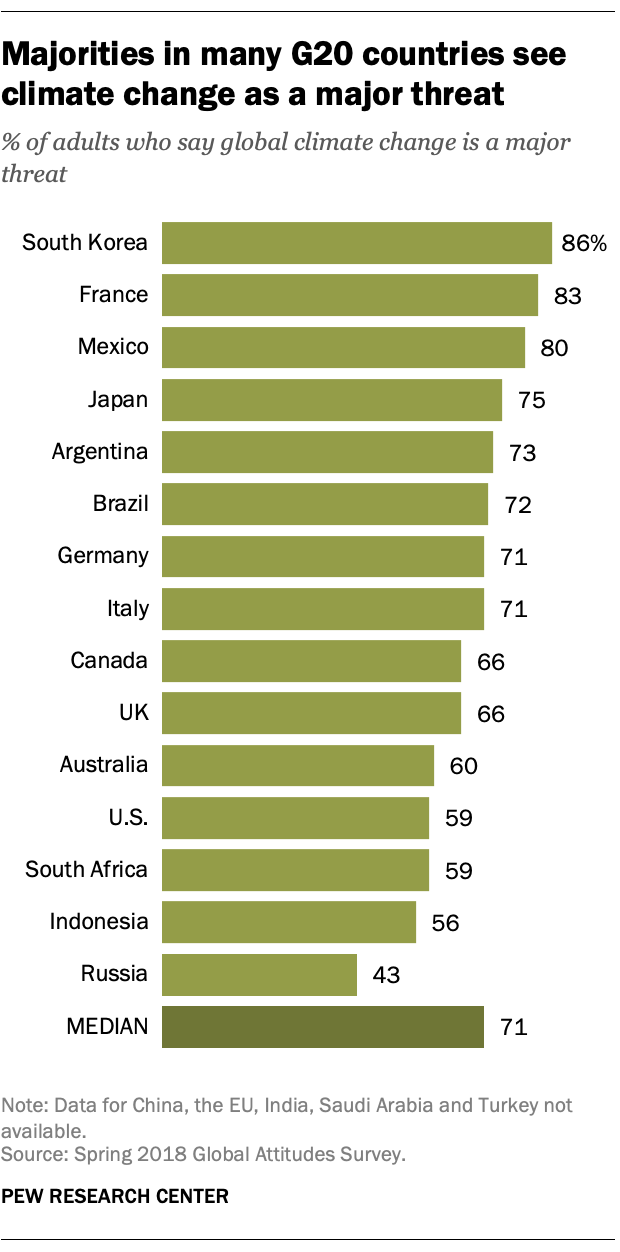

2. Title: 
                        Thinking about the causes of climate change, which, if any, of the following best describes your opinion?
                    
   Content:  This survey is part of a climate change public attitude survey in the United Kingdom (UK) in 2020. 'Climate change is partly caused by natural processes and partly caused by human activity' was the most popular response, with 39 percent of respondents saying that was the statement most closely reflecting their views. 
   Score: 1.5861431



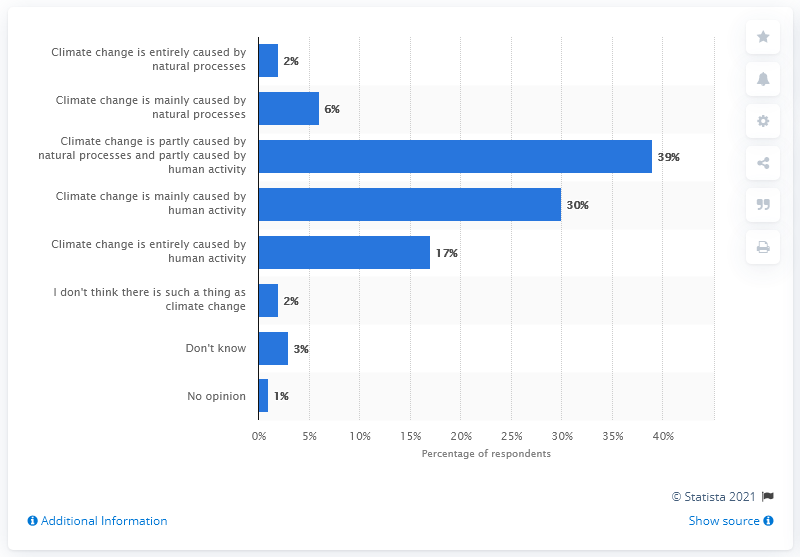

3. Title: A majority of U.S. adults say climate change is affecting their local community at least some
   Content: Roughly six-in-ten U.S. adults (62%) say climate change is currently affecting their local community either a great deal or some, according to a new Pew Research Center survey. This finding is consistent with a 2018 Center survey, in which 59% of Americans said global climate change was affecting their local community at least some.
   Score: 1.5851684



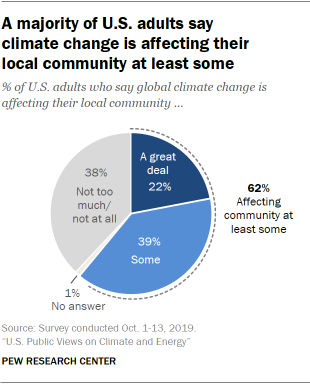

In [26]:
# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
            "params": {"query_vector": topic_embedding}
        }
    }
}
    
# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{random_topic}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data
    image_bytes = base64.b64decode(doc['image_data'])
    
    # Open the image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    
    # Display the image
    image.show()